In [190]:
import obspy
import matplotlib.pyplot as plt
import ambient2

from obspy import UTCDateTime
from scipy.fftpack import fft,ifft
from spectrum.tools import nextpow2
from obspy.signal.util import smooth
from scipy.ndimage import uniform_filter1d
from ambient2.utils import running_average_norm
#%matplotlib inline

### Introduction

In most cases, ambient noise studies use only one component of ground motion (e.g., vertical vertical cross correlations) in order to extract either Rayleigh wave of Love wave signals. However, we can extract more information if we use correlations of cross-components (e.g., correlating vertical with horizontal components). One parameter of interest is the H/V ratio of Rayleigh waves, which is a measure of how elliptical the orbit is. While measuring H/V is straightforward for ballistic surface waves, it is not as straightforward for ambient noise correlations.

In ambient noise cross data processing, individual daily records are typically normalized in the time domain, for example with a running average (citation), and spectrally whitened (citation). However, if these technqiues are used separately for each component, the relative amplitude information is lost. Lin et al. (2014) introduce the following method for three component time domain and frequency domain normalization that preserves relative amplitude information.


"_A 128-s-time window running absolute mean (Bensen et al. 2007) is applied to the 15–60 s bandpassed signals to calculate the temporal normalization func- tion. For each station and each time, we divide all the unfiltered three component noise records simultaneously by the maximum of the temporal normalization functions from the three components to suppress earthquake signals. After temporal normalization, we then perform spectral whitening by dividing the spectrum of each component by the average of the three-component smoothed spectrum_"


In [191]:
def running_average_norm(st,window_s,samprate,mode='single',freqmin=1./60, freqmax=1/15.):
    '''
    Performs a running average time domain normalization, as
    described in Bensen et al. (2007)

    st: obspy stream
    window_s: half duration of averaging window in s
    mode: 'single' if you want to perform the average on each
          trace individually.
          'multi' if you want to normalize based on the maximum
          envelope of a three component stream. (see Lin et al. 2014)
    '''
    
    st_original = st.copy() #unfiltered data
    st.filter('bandpass',freqmin=freqmin,freqmax=freqmax,corners=4,zerophase=True)

    npts = np.int(window_s * samprate)
    print npts

    if mode =='single':

        for i,tr in enumerate(st):
            data = tr.copy().data
            data = np.abs(data)
            data_s = smooth(data,npts)
            #tr.data /= data_s
            st_original[i].data /= data_s

    elif mode == 'multi':

        stations = []
        for tr in st:
            stations.append(tr.stats.station)

        unique_stations = np.unique(stations)
        for station in unique_stations:
            st_here = st.select(station=station)
            st_here_original = st_original.select(station=station)
            print st_here

            if len(st_here) < 2:
                warnings.warn('stream length less than two for "multi"')

            w_list = []
            labels = []
            for tr_here in st_here:
                sig_abs = np.abs(tr_here.copy().data)
                sig_abs_s = smooth(sig_abs,npts)
                w_list.append(sig_abs_s)
                labels.append(tr_here.stats.channel)

            w_arr = np.array(w_list)
            w = np.max(w_arr,axis=0)
            
            #make sure its doing what i think its doing
            print w_arr.shape
            plt.plot(w_arr[0,:],label=labels[0])
            plt.plot(w_arr[1,:],label=labels[1])
            plt.plot(w_arr[2,:],label=labels[2])
            plt.plot(w,label='max all')
            plt.title('Normalization function: {}'.format(tr_here.stats.station))
            plt.legend()
            plt.show()

            #apply weights
            for tr_here in st_here_original:
                tr_here.data /= w
    return st_here_original

In [192]:
def whiten(st, samprate, pw=0.8, mode='single', flim=None):
    '''
    This function performs a partial whitening of signal contained in vector S.
    The parameter 'pw' ranges from 0 to 1 where 0 represents no spectral whitening
    and 1 represents complete spectral whitening.

    The whitening is performed in the frequency domain with parameter PW according to

                        S(f)
        W(f) = ---------------------------------
                      (abs(S(f))).^PW

    where the division is only performed for non zero value of S(f), otherwise
    W(f) is set to 0.  If optional vector 'flim' = [fl, fh] is given, then
    only the frequencies between fl and fh are whitened.  The rest of the
    frequencies are set to zero.

    The output W will be the same size as S and is the time domain whitened signal.
    If S is matrix, this program will perform a columnwise whitening of the signal.

    mode = 'single' or 'multi'. If single, loops through a stream and applies the
           whitening individually to each trace. If multi, will whiten each channel
           of a station by the average of their multi-component smoothed spectra.
    '''

    #get params
    smw = 10 # 10 point smoothing

    if mode == 'single':
        for i,tr in enumerate(st):

            data = tr.data
            len_in = len(tr.data)
            endtime = tr.stats.endtime

            nfftpow = nextpow2(len(data))
            nfft = 2**nfftpow
            s_w = fft(data,n=nfft)
            s_w2 = np.abs(s_w)
            s_w2 = uniform_filter1d(s_w2, smw) #10 point smoothing

            #nz_ind = np.where(np.abs(s_w) != 0) #find non zero spectral values
            s_white = s_w / np.abs(s_w2)**pw
            data_white = ifft(s_white,n=nfft)
            data_white = data_white[0:len_in]
            tr.data = data_white.real

    elif mode == 'multi':
        stations = []
        for tr in st:
            stations.append(tr.stats.station)

        unique_stations = np.unique(stations)
        for station in unique_stations:
            st_here = st.select(station=station)
            print 'STATION', station, len(st_here)

            #get average of smoothed spectra
            spectra = []
            labels = []

            for tr_here in st_here:
                print 'STATION CODE = ', tr_here.stats.station

                labels.append(tr_here.stats.channel)
                data = tr_here.data
                len_in = len(tr_here.data)
                nfftpow = nextpow2(len(data))
                nfft = 2**nfftpow
                s_w = fft(data,n=nfft)
                s_w2 = np.abs(s_w)
                s_w2 = uniform_filter1d(s_w2, smw) #10 point smoothing
                spectra.append(s_w2)

            spectra = np.array(spectra)
            spectra_avg = np.average(spectra,axis=0)
            
            #make sure its doing what i think its doing
            print spectra.shape
            
            plt.loglog(spectra[0,:],label=labels[0])
            plt.loglog(spectra[1,:],label=labels[1])
            plt.loglog(spectra[2,:],label=labels[2])
            plt.loglog(spectra_avg,label='average')
            
            #plt.semilogx(spectra[0,:],label=labels[0])
            #plt.semilogx(spectra[1,:],label=labels[1])
            #plt.semilogx(spectra[2,:],label=labels[2])
            #plt.semilogx(spectra_avg,label='average')
            
            plt.title(tr_here.stats.station)
            plt.legend()
            plt.show()
            
            for tr_here in st_here:
                data = tr_here.data
                len_in = len(tr_here.data)
                nfftpow = nextpow2(len(data))
                nfft = 2**nfftpow
                s_w = fft(data,n=nfft)
                s_white = s_w / np.abs(spectra_avg)**pw
                data_white = ifft(s_white,n=nfft)
                data_white = data_white[0:len_in]
                tr.data = data_white.real

    return st

128
3 Trace(s) in Stream:
TA.D12A..BHE | 2009-02-01T02:00:00.000000Z - 2009-02-01T22:00:00.000000Z | 1.0 Hz, 72001 samples
TA.D12A..BHN | 2009-02-01T02:00:00.000000Z - 2009-02-01T22:00:00.000000Z | 1.0 Hz, 72001 samples
TA.D12A..BHZ | 2009-02-01T02:00:00.000000Z - 2009-02-01T22:00:00.000000Z | 1.0 Hz, 72001 samples
(3, 72001)


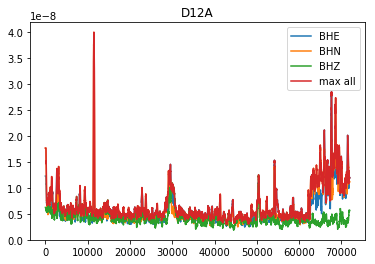

3 Trace(s) in Stream:
TA.D24A..BHE | 2009-02-01T02:00:00.000000Z - 2009-02-01T22:00:00.000000Z | 1.0 Hz, 72001 samples
TA.D24A..BHN | 2009-02-01T02:00:00.000000Z - 2009-02-01T22:00:00.000000Z | 1.0 Hz, 72001 samples
TA.D24A..BHZ | 2009-02-01T02:00:00.000000Z - 2009-02-01T22:00:00.000000Z | 1.0 Hz, 72001 samples
(3, 72001)


In [193]:
data_dir = ambient2.__path__[0]+"/../data/examples/"
st = obspy.read(data_dir+'day_000.mseed')
start = UTCDateTime(2009, 2, 1, 2)
end = UTCDateTime(2009,2,1,22)
st.trim(starttime=start,endtime=end)

samprate = st[0].stats.sampling_rate
st_running_average = running_average_norm(st.copy(),window_s=128.0,samprate=samprate,mode='multi')

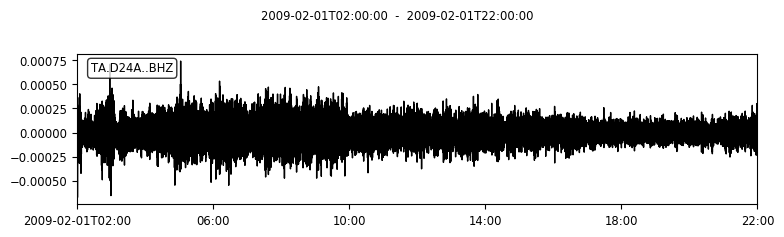

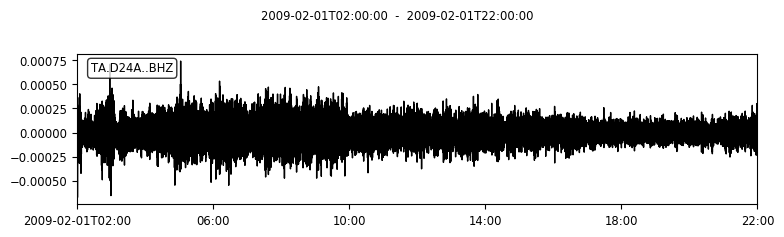

In [204]:
st_running_average[2].plot()

In [194]:
data_dir = ambient2.__path__[0]+"/../data/examples/"
st = obspy.read(data_dir+'day_000.mseed')
#st_d12a = st.select(station='D12A')


In [195]:
st_white = whiten(st_running_average, samprate=samprate, mode='multi', flim=None)

STATION D24A 3
STATION CODE =  D24A
STATION CODE =  D24A
STATION CODE =  D24A
(3, 131072)


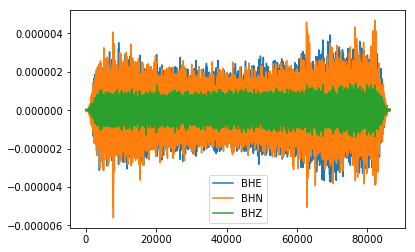

In [196]:
for tr in st.copy().select(station='D12A'):
    plt.plot(tr.data,label=tr.stats.channel)
plt.legend()
plt.show()
for tr in st.copy().select(station='D24A'):
    plt.plot(tr.data,label=tr.stats.channel)
plt.legend()
plt.show()

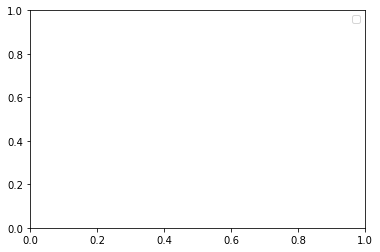

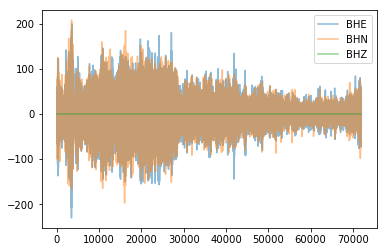

In [197]:
for tr in st_running_average.copy().select(station='D12A'):
    plt.plot(tr.data,label=tr.stats.channel,alpha=0.5)
plt.legend()
plt.show()
for tr in st_running_average.copy().select(station='D24A'):
    plt.plot(tr.data,label=tr.stats.channel,alpha=0.5)
plt.legend()
plt.show()

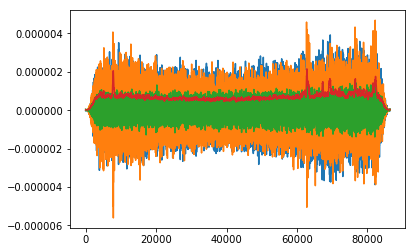

In [198]:
d0 = st.select(station='D24A')[0].data
d1 = st.select(station='D24A')[1].data
d2 = st.select(station='D24A')[2].data

s0 = smooth(np.abs(d0),128)
s1 = smooth(np.abs(d1),128)
s2 = smooth(np.abs(d2),128)
#s0 = np.abs(smooth(d0,128))
#s1 = np.abs(smooth(d1,128))
#s2 = np.abs(smooth(d2,128))

w_arr = []
w_arr.append(s0)
w_arr.append(s1)
w_arr.append(s2)
w_arr = np.array(w_arr)
weight = np.max(w_arr,axis=0)


#plt.plot(np.abs(d0))
plt.plot(d0)
plt.plot(d1)
plt.plot(d2)

#plt.plot(s0)
#plt.plot(s1)
#plt.plot(s2)

plt.plot(weight)

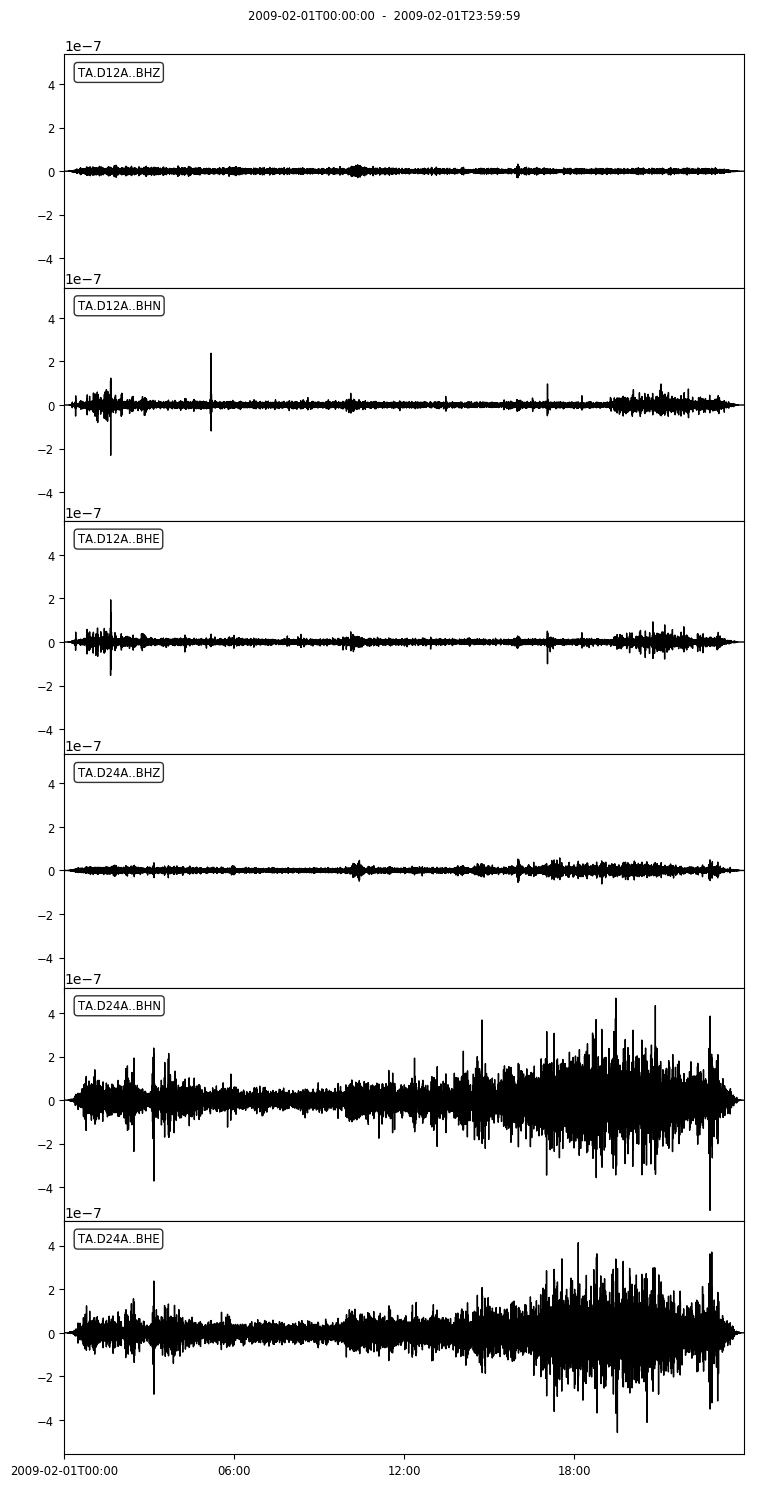

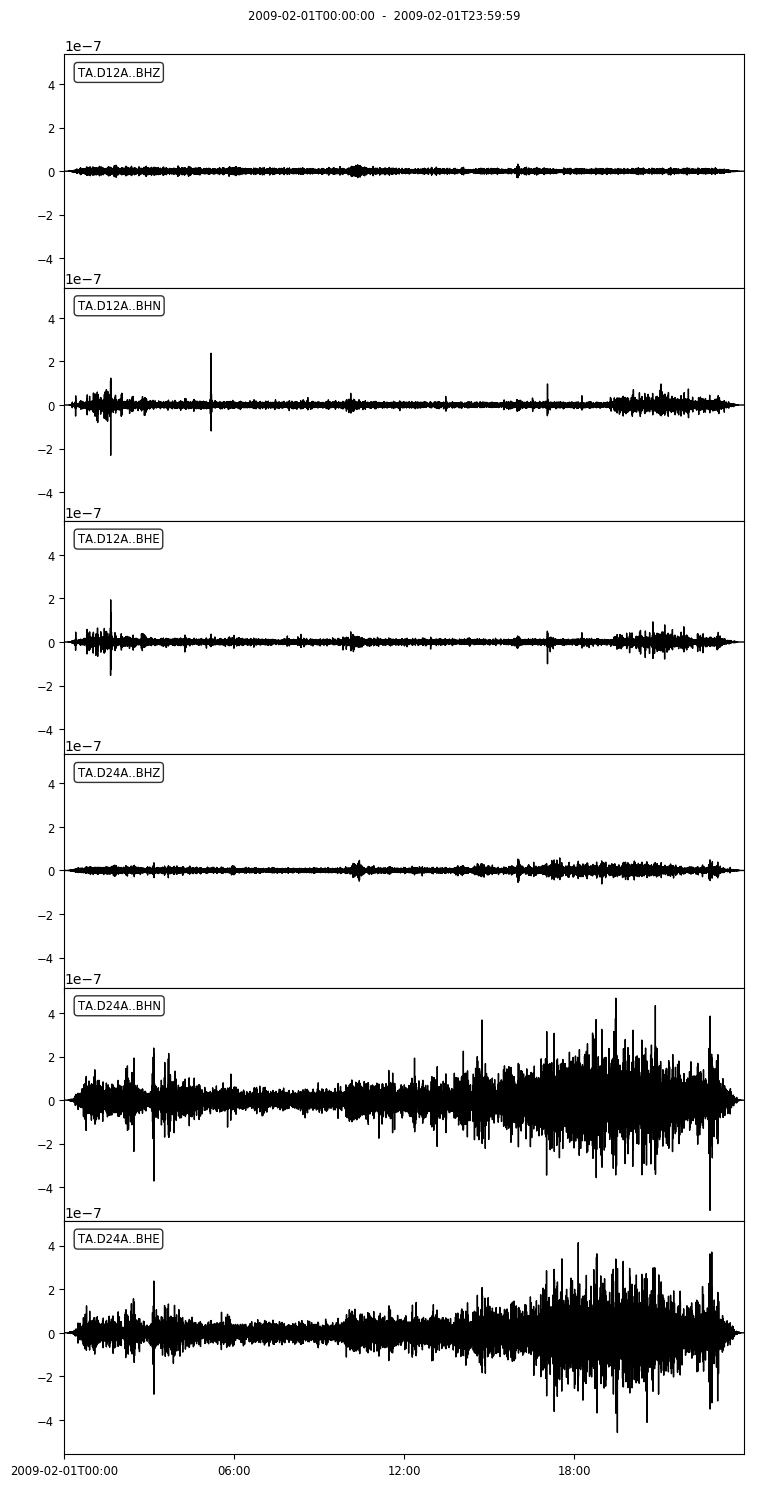

In [199]:
st = obspy.read(data_dir+'day_000.mseed')
st.filter('bandpass',freqmin=1./60,freqmax=1./15,corners=4,zerophase=True)
st.plot()

In [200]:
print st

6 Trace(s) in Stream:
TA.D12A..BHE | 2009-02-01T00:00:00.000000Z - 2009-02-01T23:59:59.000000Z | 1.0 Hz, 86400 samples
TA.D12A..BHN | 2009-02-01T00:00:00.000000Z - 2009-02-01T23:59:59.000000Z | 1.0 Hz, 86400 samples
TA.D12A..BHZ | 2009-02-01T00:00:00.000000Z - 2009-02-01T23:59:59.000000Z | 1.0 Hz, 86400 samples
TA.D24A..BHE | 2009-02-01T00:00:00.000000Z - 2009-02-01T23:59:59.000000Z | 1.0 Hz, 86400 samples
TA.D24A..BHN | 2009-02-01T00:00:00.000000Z - 2009-02-01T23:59:59.000000Z | 1.0 Hz, 86400 samples
TA.D24A..BHZ | 2009-02-01T00:00:00.000000Z - 2009-02-01T23:59:59.000000Z | 1.0 Hz, 86400 samples
